<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task10_(Ultra_Pro)_%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CVAE - Cats & Dogs

In [1]:
#!pip install keras==2.0 -q # загружаем эту версию кераса для корректной работы скрипта
#!pip install tensorflow==1.13.0rc1 -q  # загружаем эту версию тензорфлоу  для корректной работы скрипта

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
import sys
import time, random
import tensorflow as tf
import tensorflow_probability as tfp
from google.colab import files
from google.colab import drive
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Activation, Lambda, LeakyReLU, Conv2DTranspose, MaxPooling2D, Conv2D #Базовые слои
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist, fashion_mnist # загружаем готовые базы mnist
from tensorflow.keras.losses import binary_crossentropy # импортируем функцию потерь
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, multivariate_normal # модуль с нормальными непрерывными случайными величинами
from tensorflow.keras import backend as K # устанавливаем переменную для окружения кераса
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!rm -R '/content/dogscats' #remove texts directory
!unzip -q "/content/drive/MyDrive/Colab Notebooks/dogs-vs-cats.zip" -d /content/dogscats #Указываем путь к базе в Google Drive

In [4]:
train_path_img = '/content/dogscats/dogs-vs-cats' #directory with images
img_width = 128 #Ширина изображения
img_height = 128 #Высота изображения
latent_dim = 1524 # размер скрытого слоя/пространства
#dropout_rate = 0.2 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения

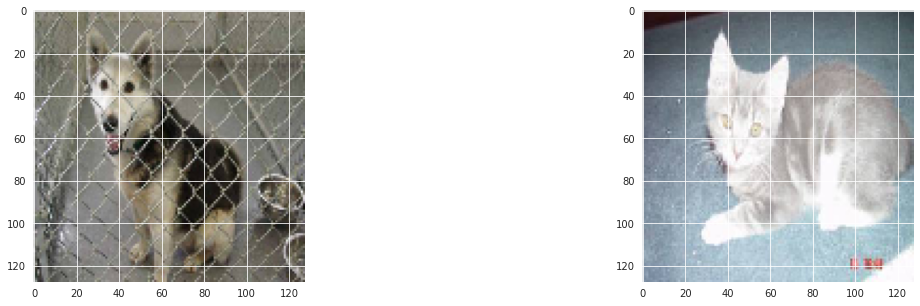

In [5]:
#Выводим для примера картинки по каждому классу
fig, axs=plt.subplots(1,2,figsize=(20,5))
for i in range(2):
  pet_path = train_path_img + '/' + os.listdir(train_path_img)[i] + '/'#Формируем путь к выборке
  img_path = pet_path + random.choice(os.listdir(pet_path)) #Выбираем случайное фото для отображения
  axs[i].imshow(image.load_img(img_path, target_size=(img_height, img_width))) #Отображение фотографии
plt.show()

In [6]:
x_train=[]
y_train=[]

for i in range(2):
  for j in range(4000):
    pet_path = train_path_img + '/' + os.listdir(train_path_img)[i] + '/'
    img_path = pet_path + os.listdir(pet_path)[j]
    img=image.load_img(img_path, target_size=(img_height, img_width))
    x=np.array(img)/255
    c=i

    x_train.append(x)
    y_train.append(c)

x_train=np.array(x_train)
y_train=np.array(y_train)
y_train = to_categorical(y_train, 2).astype(np.float32)
num_classes = y_train.shape[1]
print(x_train.shape)
print(y_train.shape)
print(num_classes)

(8000, 128, 128, 3)
(8000, 2)
2


[0. 1.]


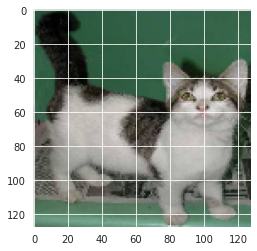

In [7]:
i=4500
img=x_train[i]*255
img = img.astype('uint8')
img=img.reshape(128,128,3)
print(y_train[i])
plt.imshow(img)

In [8]:
#Генератор изображений
#datagen = ImageDataGenerator(
    #rescale=1. / 255, #Значения цвета меняем на дробные показания
    #rotation_range=10, #Поворачиваем изображения при генерации выборки
    #width_shift_range=0.1, #Двигаем изображения по ширине при генерации выборки
    #height_shift_range=0.1, #Двигаем изображения по высоте при генерации выборки
    #zoom_range=0.1, #Зумируем изображения при генерации выборки
    #horizontal_flip=True, #Включаем отзеркаливание изображений
    #fill_mode='nearest', #Заполнение пикселей вне границ ввода
    #validation_split=0.2 #Указываем разделение изображений на обучающую и тестовую выборку)

In [9]:
# обучающая выборка
#train_generator = datagen.flow_from_directory(
    #train_path_img, #Путь ко всей выборке выборке
    #target_size=(img_width, img_height), #Размер изображений
    #batch_size=batch_size, #Размер batch_size
    #class_mode='input', #Категориальный тип выборки. Разбиение выборки по маркам авто 
    #shuffle=True, #Перемешивание выборки
    #subset='training' # устанавливаем как набор для обучения)

# проверочная выборка
#validation_generator = datagen.flow_from_directory(
    #train_path_img, #Путь ко всей выборке выборке
    #target_size=(img_width, img_height), #Размер изображений
    #batch_size=batch_size, #Размер batch_size
    #class_mode='input', #Категориальный тип выборки. Разбиение выборки по маркам авто 
    #shuffle=True, #Перемешивание выборки
    #subset='validation' # устанавливаем как валидационный набор)

In [10]:
def create_cvae(): 
    models = {} 

    # Энкодер
    input_img = Input((128, 128, 3)) 
    input_lbl = Input(shape=(num_classes,), dtype='float32')
    
    x1 = Conv2D(1, (4, 4), activation='sigmoid', padding='same')(input_img)
    x2 = Conv2D(1, (2, 2), activation='sigmoid', padding='same')(input_img)
    x3 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(input_img)
    enc=concatenate([x1,x2,x3])

    enc=Conv2D(32, (4, 4), activation='elu', padding='same', strides=2)(enc)
    enc=Conv2D(64, (4, 4), activation='elu', padding='same', strides=2)(enc)
    enc=Conv2D(128, (4, 4), activation='elu', padding='same', strides=2)(enc)
    enc=Conv2D(256, (4, 4), activation='elu', padding='same', strides=2)(enc)
    enc=Conv2D(512, (4, 4), activation='elu', padding='same', strides=2)(enc)
    enc_shape=(4,4,512)
    enc = Flatten()(enc)
    enc = Dense(512, activation='elu')(enc)
    enc = Dense(256, activation='elu')(enc)
    enc = concatenate([enc,input_lbl])
    
    z_mean = Dense(latent_dim, activation='softplus')(enc) # скрытое пространство(мат.ожидание) размером 
    z_log_var = Dense(latent_dim, activation='elu')(enc) # скрытое пространство(лог.вариации) размером 

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        [z_mean, z_log_var] = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        z=z_mean + tf.multiply(tf.sqrt(tf.exp(z_log_var)),tf.random.normal(shape=(tf.shape(z_log_var))))
        return z

    # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

    models["encoder"]  = Model([input_img, input_lbl], l) # модель энкодера от входа до лямбда слоя
    models["z_meaner"] = Model([input_img, input_lbl], z_mean) # отдельная модель с путем от входа до z_mean
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var) # отдельная модель с путем от входа до z_log_var

    # Декодер
    input_dec = Input(shape=(latent_dim, )) # задаем первую входную размерность
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') 
    dec = Dense(256, activation='elu')(input_dec) 
    dec = Dense(512, activation='elu')(dec)
    dec=concatenate([dec,input_lbl_d])
    dec = Dense(np.prod(np.array(enc_shape)), activation='relu')(dec) 
    dec = Reshape(enc_shape)(dec) # меняем форму, приводим к нужным нам размерам
    dec = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', activation='elu')(dec) # слой разжимает данные
    dec = Conv2D(256, (4, 4), activation='elu', padding='same')(dec)
    dec = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='elu')(dec) # слой разжимает данные
    dec = Conv2D(128, (4, 4), activation='elu', padding='same')(dec)
    dec = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='elu')(dec) # слой разжимает данные
    dec = Conv2D(64, (4, 4), activation='elu', padding='same')(dec)
    dec = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='elu')(dec)
    dec = Conv2D(32, (4, 4), activation='elu', padding='same')(dec)
    dec = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', activation='elu')(dec)
    x1 = Conv2D(1, (4, 4), activation='sigmoid', padding='same')(dec)
    x2 = Conv2D(1, (2, 2), activation='sigmoid', padding='same')(dec)
    x3 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(dec)
    # Финальный слой двумерной свертки, выдающий итоговое изображение
    output_dec = concatenate([x1,x2,x3])

    models["decoder"] = Model([input_dec, input_lbl_d], output_dec, name='Decoder') # собираем модель декодера
    
    # Cобираем вариационный автокодировщик, также двойное преобразование над входной картинкой(энкодер-декодер)
    models["cvae"] = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , 
                               name="style_transfer")
    
    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        kl_divergence=tf.reduce_sum(tf.keras.metrics.kullback_leibler_divergence(x, decoded), axis=[1,2])
        x=tf.reshape(x, shape=(-1, 3*img_width*img_height))
        decoded=tf.reshape(decoded, shape=(-1, 3*img_width*img_height))
        reconstruction_term=-tf.reduce_sum(tfp.distributions.MultivariateNormalDiag(decoded, scale_diag=[tf.repeat(0.05,tf.shape(x)[1])]).log_prob(x))
        cost=tf.reduce_mean(reconstruction_term + kl_divergence)#/3/img_width/img_height
        return cost

    return models, vae_loss

models, vae_loss = create_cvae() # получаем модели и свою функцию потерь
cvae = models["cvae"] # задаем модель вариационного автокодировщика с условием
generator = models["decoder"]

In [11]:
def plotImages(xTrain, pred, shape=(128, 128,3)): # создадим функцию для вывода изображений как картинок
  n = 10  # количество картинок, которые хотим показать
  plt.figure(figsize=(25, 5)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки  
      #plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 
      #plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [12]:
# Эпохи, в которые будем сохранять
batch_size = 100
save_epochs = set([i*5 for i in range(0,30)])
imgs = x_train[:batch_size]
imgs_lbls = y_train[:batch_size]

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls])
        decoded=decoded*255
        decoded = decoded.astype('uint8')
        plotImages(imgs, decoded, shape=(128,128,3))
    
# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

In [13]:
#lr = 0.0001 # шаг обучения
#cvae.compile(optimizer = Adam(learning_rate=lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [14]:
#history=cvae.fit([x_train, y_train, y_train], x_train, shuffle=True, epochs=150, callbacks=[pltfig], verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

In [15]:
#cvae.save_weights('/content/drive/MyDrive/cvae_train.h5')

In [16]:
#Выводим графики
#plt.figure(figsize=(14,7))
#plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
#plt.ylabel('Ошибка')
#plt.legend()
#plt.show()

In [17]:
cvae.load_weights('/content/drive/MyDrive/cvae_train.h5')

In [18]:
lr = 0.00001 # шаг обучения
cvae.compile(optimizer = Adam(learning_rate=lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

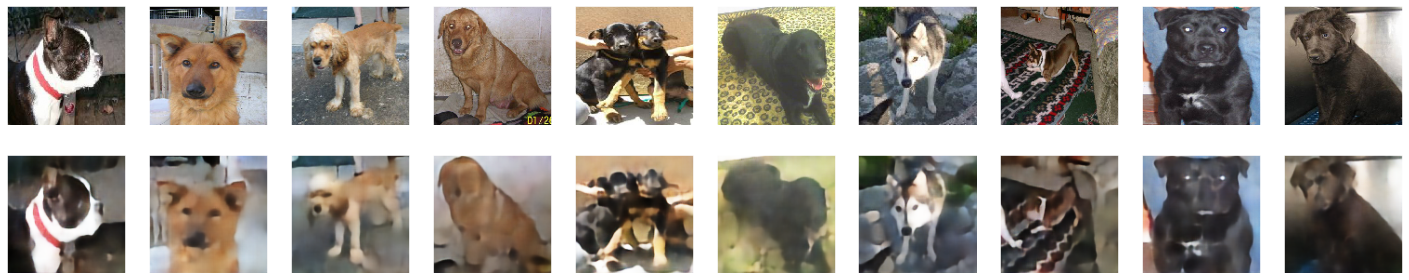

Epoch 147/150
250/250 [==============================] - 64s 257ms/step - loss: -1751355.6250
Epoch 148/150
250/250 [==============================] - 64s 257ms/step - loss: -1752534.3750
Epoch 149/150
250/250 [==============================] - 64s 257ms/step - loss: -1753479.0000
Epoch 150/150
250/250 [==============================] - 64s 256ms/step - loss: -1754254.1250


In [19]:
history=cvae.fit([x_train, y_train, y_train], x_train, shuffle=True, epochs=150,
         #batch_size=batch_size,
         callbacks=[pltfig],
         verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

In [20]:
cvae.save_weights('/content/drive/MyDrive/cvae_dogd&cats.h5')